<a href="https://colab.research.google.com/github/Eggathin/potential-enigma/blob/main/STA365_H3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import requests
import pymc as pm

The dataset I chose includes age, gender, height, weight, body mass index (BMI), and physical activity level as factors influencing the obesity level of an individual.

In [2]:
# import and read dataset

url = 'https://github.com/Eggathin/potential-enigma/blob/main/obesity_data.csv?raw=true'
df = pd.read_csv(url)
print(df.head(5))
df.describe()

   Age  Gender      Height     Weight        BMI  PhysicalActivityLevel  \
0   56    Male  173.575262  71.982051  23.891783                      4   
1   69    Male  164.127306  89.959256  33.395209                      2   
2   46  Female  168.072202  72.930629  25.817737                      4   
3   32    Male  168.459633  84.886912  29.912247                      3   
4   60    Male  183.568568  69.038945  20.487903                      3   

  ObesityCategory  
0   Normal weight  
1           Obese  
2      Overweight  
3      Overweight  
4   Normal weight  


,Age,Height,Weight,BMI,PhysicalActivityLevel
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,49.857000,170.052417,71.205769,24.888317,2.534000
std,18.114267,10.309971,15.509849,6.193912,1.116284
min,18.000000,136.115719,26.065730,8.470572,1.000000
25%,35.000000,163.514205,61.129629,20.918068,2.000000
50%,50.000000,169.801665,71.929072,24.698647,3.000000
75%,66.000000,177.353596,81.133746,28.732132,4.000000
max,79.000000,201.419670,118.907366,50.791898,4.000000


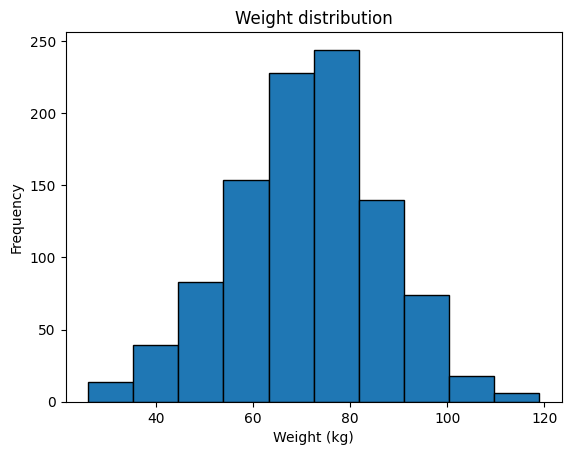

In [3]:
# plot histogram of the column with normal data

plt.hist(df['Weight'], bins=10, edgecolor='black')
plt.xlabel('Weight (kg)')
plt.ylabel('Frequency')
plt.title('Weight distribution')
plt.show()

In [4]:
# Set up normal-gamma model

with pm.Model() as normal_gamma_weight_model:
  # priors
  theta = pm.Normal('theta', mu=0, sigma=1)
  phi = pm.Gamma('phi', alpha=1, beta=1)

  # likelihood
  likelihood = pm.Normal('likelihood', mu=theta, sigma=1/phi**0.5, observed=df["Weight"])

In [5]:
# Hamiltonian MC sampling
random.seed(123)
with normal_gamma_weight_model:
  idata_HMC = pm.sample()

array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

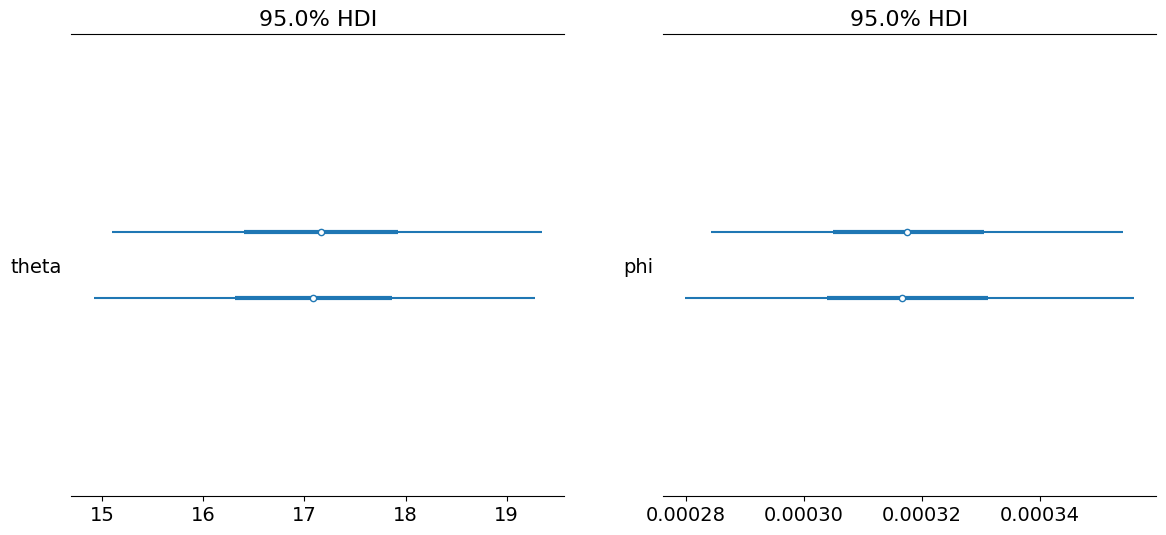

In [8]:
fig,ax = plt.subplots(1,2,figsize=(14,6))
az.plot_forest(idata_HMC, var_names=["theta"], combined=False, hdi_prob=0.95, ax=ax[0])
az.plot_forest(idata_HMC, var_names=["phi"], combined=False, hdi_prob=0.95, ax=ax[1])

HMC Split-Rhats {'theta': 0.9997, 'phi': 1.0003}


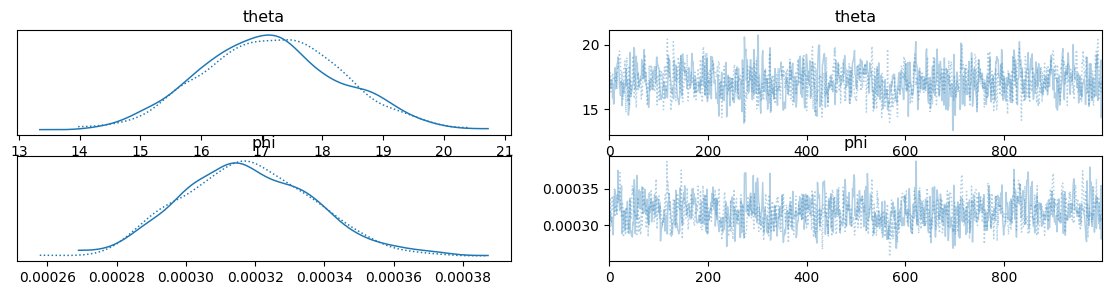

In [16]:
import arviz as az
fig, ax = plt.subplots(2,2, figsize=(14,3))
az.plot_trace(idata_HMC, axes=ax[:2,:2])
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(idata_HMC).items()})

In [7]:
# summary statistics
print("number of MCMC samples:", idata_HMC.posterior['phi'].values.flatten().shape[-1])
az.summary(idata_HMC, round_to=2)

number of MCMC samples: 2000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,17.15,1.13,15.1,19.31,0.04,0.03,893.73,1003.38,1.0
phi,0.00,0.00,0.0,0.00,0.00,0.00,686.42,1019.72,1.0


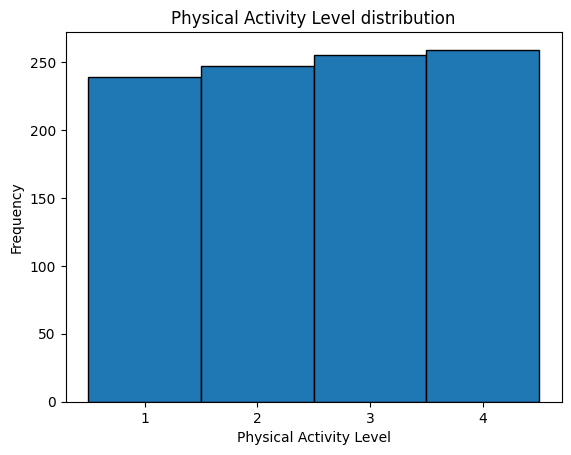

In [41]:
# plot histogram of the column with non-normal data

plt.hist(df['PhysicalActivityLevel'], bins=np.arange(1, 5.5) - 0.5, edgecolor='black')
plt.xticks(np.arange(1, 5, 1))
plt.xlabel('Physical Activity Level')
plt.ylabel('Frequency')
plt.title('Physical Activity Level distribution')
plt.show()

Since the Physical Activity Level variable is not normally distributed, it would be inappropriate to use a normal-gamma specification. Instead, we choose to assume a discrete uniform likelihood for the data.

In [10]:
with pm.Model() as PAL_model:
  theta = pm.DiscreteUniform("theta", lower=1, upper=4)

  # likelihood
  likelihood = pm.DiscreteUniform("likelihood", lower=1, upper=4, observed=df['PhysicalActivityLevel'])

In [11]:
# prompt: sample the above distribution

with PAL_model:
  PAL_HMC = pm.sample()

array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

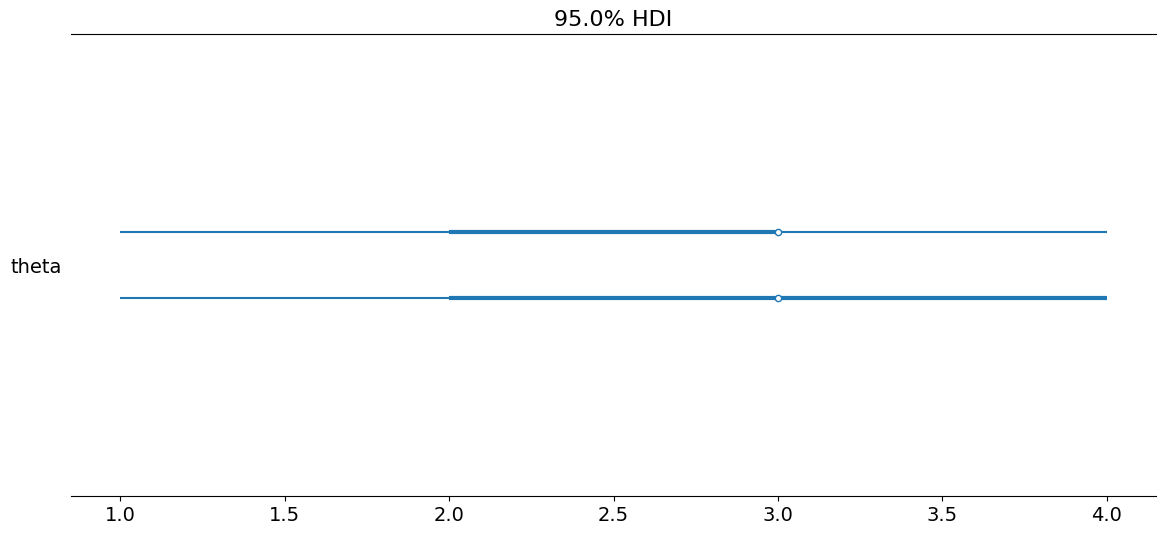

In [14]:
fig,ax = plt.subplots(1,1,figsize=(14,6))
az.plot_forest(PAL_HMC, var_names=["theta"], combined=False, hdi_prob=0.95, ax=ax)

HMC Split-Rhats {'theta': 1.0046}


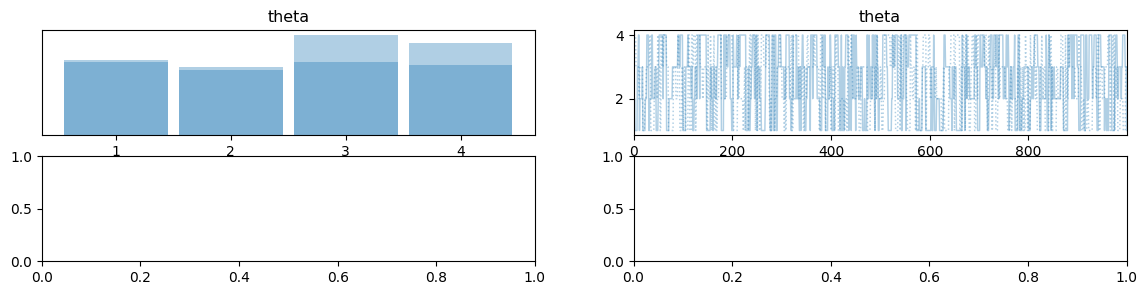

In [38]:
fig, ax = plt.subplots(2,2, figsize=(14,3))
az.plot_trace(PAL_HMC, axes=ax)
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(PAL_HMC).items()})

In [13]:
print("number of MCMC samples:", idata_HMC.posterior['phi'].values.flatten().shape[-1])
az.summary(PAL_HMC, round_to=2)

number of MCMC samples: 2000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,2.57,1.12,1.0,4.0,0.05,0.04,524.91,583.1,1.0


Since r-hat is 1, it shows that the MCMC chains have converged. The trace patterns shows some oscillation and ESS is relatively low compared to the sample number, suggesting that the MCMC chain is somewhat inefficient.